In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import healpy as hp
from healpy.newvisufunc import projview
import itertools as it
import fitsio
from astropy.coordinates import SkyCoord, Angle
import astropy.units as u
import time
import os
import sys
sys.path.insert(0, '/home/aew492/lss-dipoles')
import tools
from Secrest_dipole import SecrestDipole
import dipole
from ellisbaldwin import compute_expected_dipole_gaia
from jackknife import get_longitude_subsamples_from_hpmap, compute_jackknife_uncertainty, covar_jackknife

### functions

Function to measure dipole from a healpix map of overdensities: required for `compute_jackknife_uncertainty()` but also nice to have here to keep the fitting choices
in this notebook clear (`Wmask`, etc.)

In [3]:
def measure_dipole_in_overdensity_map(sample, selfunc=None, Wmask=0.1):
    map_to_fit = sample.copy()
    idx_masked = np.isnan(map_to_fit)
    map_to_fit[idx_masked] = 0.
    Cinv = np.ones_like(sample) if np.all(selfunc == None) else selfunc.copy()
    Cinv[idx_masked] = Wmask
    amps, stderr = dipole.fit_dipole(map_to_fit, Cinv=Cinv, fit_zeros=True)
    return amps[1:] # since we're fitting overdensities

In [4]:
# not a function but kwargs for plotting overdensities
map_kwargs = dict(min=-0.5, max=0.5, coord=['C','G'], badcolor='w', unit='overdensity')

### load source catalog and get expected dipole amplitude from Ellis-Baldwin formula

In [5]:
# instantiate a dipole object and load the source density table
d = SecrestDipole(initial_catfn='quaia_G20.5.fits', catname='quaia', mag='G',
                    blim=30, maglim=20., save_tag='_r1.0', load_init=True, compcorrect=False)
d.cut_galactic_plane()

# delete the initial table to clear up memory !
del d.initial_cattab

# expected dipole amplitude: we need to set the magnitude limit at 20.4, since we don't have mag info past 20.5
maglim = 20.
expected_dipole_res = compute_expected_dipole_gaia(d.table, maglimit=maglim, min_g=19.5, max_g=20.5,
                                                   verbose=True, return_full_results=True)
expected_dipamp_full = expected_dipole_res['expected_dipamp']

# save the table before final magnitude cut, to compute expected dipole below with redshift splits
table_fullmag = d.table.copy()
d.cut_mag()

# get redshift distribution
redshifts_full = d.table['redshift_quaia']

loading initial catalog, quaia_G20.5.fits
1295502 sources in initial catalog.
cut |b| <= 30 -> 917566 sources left.
computing expected dipole from Ellis-Baldwin:
	number-count slope x = 1.309
	effective alpha = 0.713
	expected dipole amplitude = 0.0052
cut G > 20.0 -> 530364 sources left.


Text(0.5, 0.98, 'Quaia G<20.0 Ellis-Baldwin parameters')

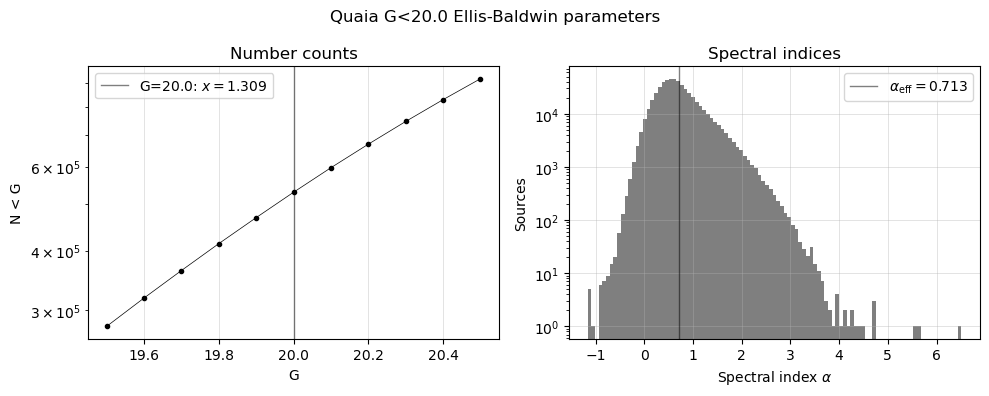

In [6]:
# make some plots
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(10,4), tight_layout=True)

mags, counts, x = expected_dipole_res['mag_grid'], expected_dipole_res['counts'], expected_dipole_res['x']
ax0.plot(mags, counts, 'k.-', lw=0.5)
ax0.axvline(maglim, color='k', alpha=0.5, lw=1, label=f'G={maglim}: 'r'$x=$'f'{x:.3f}')
ax0.set_xlabel('G')
ax0.set_ylabel('N < G')
ax0.set_title('Number counts')

alpha, alphas = expected_dipole_res['alpha'], expected_dipole_res['alphas']
_, _, _ = ax1.hist(alphas, bins=101, alpha=0.5, color='k')
ax1.axvline(alpha, color='k', alpha=0.5, lw=1, label=r'$\alpha_\mathrm{eff}=$'f'{alpha:.3f}')
ax1.set_xlabel(r'Spectral index $\alpha$')
ax1.set_ylabel(r'Sources')
ax1.set_title('Spectral indices')

for ax in (ax0, ax1):
    ax.grid(lw=0.5, alpha=0.5)
    ax.semilogy()
    ax.legend()
fig.suptitle(f'Quaia G<{d.maglim} Ellis-Baldwin parameters')

In [7]:
# SELECTION FUNCTION AND MASKS
# load selection function
selfunc = d.load_selfunc()

# mask the galactic plane (mask pixels based on their central sky coordinate)
lon, lat = hp.pix2ang(d.NSIDE, np.arange(hp.nside2npix(d.NSIDE)), lonlat=True)
b = SkyCoord(lon * u.deg, lat * u.deg, frame='icrs').galactic.b
gal_plane_mask = np.zeros(hp.nside2npix(d.NSIDE))
gal_plane_mask[np.abs(b.deg) >= d.blim] = 1

# load smaller masks (used in S21): at the pixel level
small_masks = fitsio.read(d.mask_fn)
assert len(small_masks) == len(gal_plane_mask) == hp.nside2npix(d.NSIDE)

# total mask: galactic plane, smaller masks, and where completeness < 0.5
mask = gal_plane_mask.astype(bool) & small_masks.astype(bool) & (selfunc > 0.5)

In [8]:
# OVERDENSITY MAP
# turn astropy table into healpix map
datamap = tools.load_catalog_as_map(d.table, NSIDE=d.NSIDE)

# mask the data: populate a nan map with the data values in unmasked pixels
masked_datamap = np.multiply(datamap, mask, where=(mask!=0), out=np.full_like(datamap, np.nan))

# mean density of the map: mean of the _expected_ counts
mean_density = np.nanmean(masked_datamap / selfunc)

# then the overdensity map is
overdensity_map_full = np.divide(masked_datamap, selfunc, where=mask,
                            out=np.full_like(masked_datamap, np.nan)) / mean_density - 1
                    # (fancy divide to avoid RuntimeWarnings where completeness goes to zero)

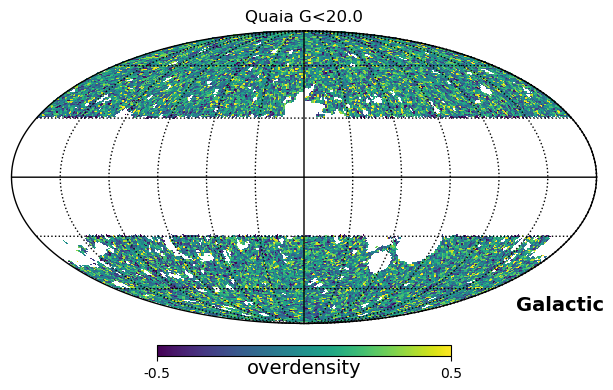

In [9]:
# plot
hp.mollview(overdensity_map_full, title=f'Quaia G<{d.maglim}', fig=plt.figure(figsize=(12,4)), sub=(1,2,1), **map_kwargs)
hp.graticule()

In [10]:
# measure dipole in the full sample
print(f"dipole measured in Quaia G<{d.maglim}:")
dipole_full = measure_dipole_in_overdensity_map(overdensity_map_full, selfunc=selfunc)
dipole_full_amp, dipole_full_dir = dipole.get_dipole(dipole_full)
print(f"\tbest-fit dipole amp. =\t{dipole_full_amp:.5f}")
print(f"\texpected dipole amp. =\t{expected_dipamp_full:.5f}\n\tratio =\t\t\t{dipole_full_amp / expected_dipamp_full:.4f}")

dipole measured in Quaia G<20.0:
	best-fit dipole amp. =	0.01187
	expected dipole amp. =	0.00523
	ratio =			2.2682


### sort sources into redshift bins - equal number of sources in each bin

In [11]:
# sort sources by redshift to get an equal number of sources in each redshift bin
def sort_table_in_bins(table, nbins, key='redshift_quaia'):
    idx_sorted = np.arange(len(table))[np.argsort(table[key])]
    idx_bins = np.array_split(idx_sorted, nbins)
    return [table[idx] for idx in idx_bins]

In [12]:
# 2 bins to work with pre-existing selfuncs: split the catalog at the median redshift
nbins = 2
t_z_sorted = sort_table_in_bins(d.table, nbins)

# redshift distribution in each bin
redshifts_z = [
    t_['redshift_quaia'] for t_ in t_z_sorted
]

# assign colors to each redshift bin to be consistent in plotting
colors = list(map(mpl.cm.Set1, range(nbins)))

Text(0.5, 1.0, 'Quaia G<20.0 redshift distributions, 2 bins')

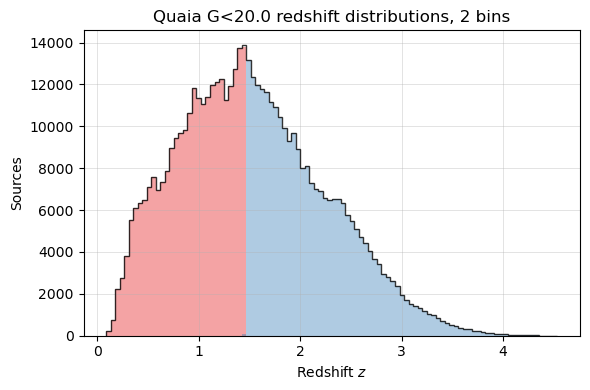

In [13]:
# plot dN/dz s
fig, ax = plt.subplots(figsize=(6,4), tight_layout=True)
bins = np.linspace(np.nanmin(redshifts_full), np.nanmax(redshifts_full), 101)
kwargs = dict(bins=bins, histtype='stepfilled', alpha=0.4)
_, _, _ = ax.hist(redshifts_full, color='k', histtype='step', alpha=0.8, bins=bins)
for i, zs in enumerate(redshifts_z):
    _, _, _ = ax.hist(zs, color=colors[i], **kwargs)
ax.grid(alpha=0.5, lw=0.5)
ax.set_xlabel(r'Redshift $z$')
ax.set_ylabel('Sources')
ax.set_title(f'Quaia G<{d.maglim} redshift distributions, {nbins} bins')

In [14]:
# EXPECTED DIPOLE AMPLITUDES
#  save full results dictionary to check parameters
expected_dipole_z_res = [
    compute_expected_dipole_gaia(t_, maglimit=maglim, min_g=19.5, max_g=20.5,
                                                   verbose=True, return_full_results=True) for t_ in t_z_sorted
]
# expected dipole amplitude for each bin
expected_dipamps_z = [
    res['expected_dipamp'] for res in expected_dipole_z_res
]

computing expected dipole from Ellis-Baldwin:
	number-count slope x = 0.620
	effective alpha = 0.663
	expected dipole amplitude = 0.0037
computing expected dipole from Ellis-Baldwin:
	number-count slope x = 0.711
	effective alpha = 0.762
	expected dipole amplitude = 0.0040


Text(0.5, 0.98, 'Quaia G<20.0 Ellis-Baldwin parameters')

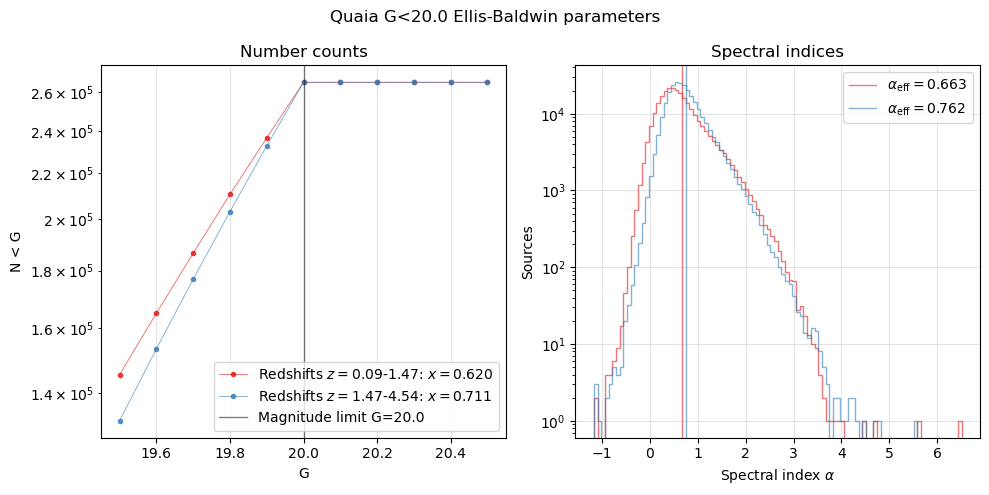

In [15]:
# make some plots
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(10,5), tight_layout=True)

# histogram bins
bins = np.linspace(np.min([res['alphas'] for res in expected_dipole_z_res]),
                   np.max([res['alphas'] for res in expected_dipole_z_res]), 101)
for i, res in enumerate(expected_dipole_z_res):
    mags, counts, x = res['mag_grid'], res['counts'], res['x']
    ax0.plot(mags, counts, marker='.', ls='-', lw=0.5, color=colors[i], alpha=0.8,
            label=f'Redshifts 'r'$z=$'f'{min(redshifts_z[i]):.2f}-{max(redshifts_z[i]):.2f}: 'r'$x=$'f'{x:.3f}')
    alpha, alphas = res['alpha'], res['alphas']
    _, _, _ = ax1.hist(alphas, bins=bins, alpha=0.6, color=colors[i], histtype='step')
    ax1.axvline(alpha, color=colors[i], alpha=0.6, lw=1, label=r'$\alpha_\mathrm{eff}=$'f'{alpha:.3f}')
    
ax0.axvline(maglim, color='k', alpha=0.5, lw=1, label=f'Magnitude limit G={maglim}')
ax0.set_xlabel('G')
ax0.set_ylabel('N < G')
ax0.set_title('Number counts')

ax1.set_xlabel(r'Spectral index $\alpha$')
ax1.set_ylabel(r'Sources')
ax1.set_title('Spectral indices')

for ax in (ax0, ax1):
    ax.grid(lw=0.5, alpha=0.5)
    ax.semilogy()
    ax.legend()
fig.suptitle(f'Quaia G<{d.maglim} Ellis-Baldwin parameters')

In [17]:
# selection functions for each redshift bin
# selfuncs_z = [
#     tools.flatten_map(fitsio.read(os.path.join(d.catdir, 'selfuncs',
#                              f'selection_function_NSIDE{d.NSIDE}_G{d.maglim}_zsplit2bin{i}.fits'))) for i in range(nbins)
# ]
selfuncs_z = [selfunc, selfunc]

mean, min, max completeness in selfunc 0 = 0.46, 0.00, 0.79
mean, min, max completeness in selfunc 1 = 0.46, 0.00, 0.79


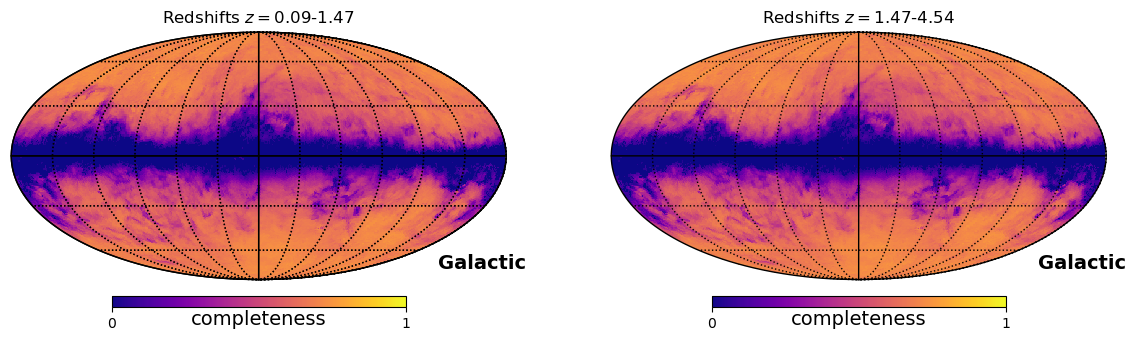

In [18]:
fig = plt.figure(figsize=(12,3))
for i, selfunc_ in enumerate(selfuncs_z):
    print(f"mean, min, max completeness in selfunc {i} = {np.nanmean(selfunc_):.2f}, {np.nanmin(selfunc_):.2f}, {np.nanmax(selfunc_):.2f}")
    hp.mollview(selfunc_, sub=(1,2,i+1), title=r'Redshifts $z=$'f'{min(redshifts_z[i]):.2f}-{max(redshifts_z[i]):.2f}',
                fig=fig, cmap='plasma', coord=['C','G'], min=0, max=1, unit='completeness')
    hp.graticule()

In [19]:
# OVERDENSITY MAP from each source density table / each redshift slice and fit dipole
overdensity_maps = np.empty((nbins, hp.nside2npix(d.NSIDE)))
for i, t_ in enumerate(t_z_sorted):
    # turn astropy table into healpix map
    datamap = tools.load_catalog_as_map(t_, NSIDE=d.NSIDE)

    # selection function
    selfunc_ = selfuncs_z[i]

    # total mask: galactic plane, smaller masks, and where completeness < 0.5
    mask_ = gal_plane_mask.astype(bool) & small_masks.astype(bool) & (selfunc_ > 0.5)
    
    # mask the data: populate a nan map with the data values in unmasked pixels
    masked_datamap = np.multiply(datamap, mask_, where=mask_, out=np.full_like(datamap, np.nan))
    
    # mean density of the map: mean of the _expected_ counts
    mean_density = np.nanmean(masked_datamap / selfunc_)
    
    # then the overdensity map is
    overdensity_maps[i] = np.divide(masked_datamap, selfunc_, where=mask_,
                                out=np.full_like(masked_datamap, np.nan)) / mean_density - 1
                        # (fancy divide to avoid RuntimeWarnings where completeness goes to zero)

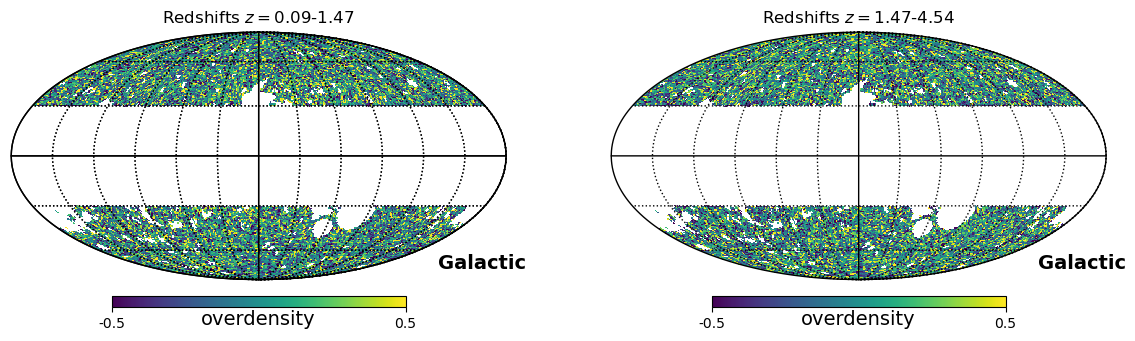

In [20]:
# plot
fig = plt.figure(figsize=(12,3))
for i, map_ in enumerate(overdensity_maps):
    mean, std = np.nanmean(map_), np.nanstd(map_)
    hp.mollview(map_, sub=(1,2,i+1), title=r'Redshifts $z=$'f'{min(redshifts_z[i]):.2f}-{max(redshifts_z[i]):.2f}', fig=fig, **map_kwargs)
    hp.graticule()

In [21]:
# FIT DIPOLE to each map
dipoles_z = np.empty((nbins,3))
for i, overdensity_map in enumerate(overdensity_maps):
    print(f"dipole measured in Quaia G<{d.maglim}, redshift bin {i}:")
    dipole_ = measure_dipole_in_overdensity_map(overdensity_map, selfunc=selfuncs_z[i])
    print(f"\tbest-fit dipole amp. =\t{np.linalg.norm(dipole_):.5f}")
    print(f"\texpected dipole amp. =\t{expected_dipamps_z[i]:.5f}\n\tratio =\t\t\t{np.linalg.norm(dipole_) / expected_dipamps_z[i]:.4f}")
    dipoles_z[i] = dipole_

dipole measured in Quaia G<20.0, redshift bin 0:
	best-fit dipole amp. =	0.01434
	expected dipole amp. =	0.00374
	ratio =			3.8344
dipole measured in Quaia G<20.0, redshift bin 1:
	best-fit dipole amp. =	0.01065
	expected dipole amp. =	0.00401
	ratio =			2.6541


### jackknife

In [22]:
# in full sample
nsamples = 12
lonavg, subsamples = get_longitude_subsamples_from_hpmap(overdensity_map_full, nsamples, input_frame='icrs')

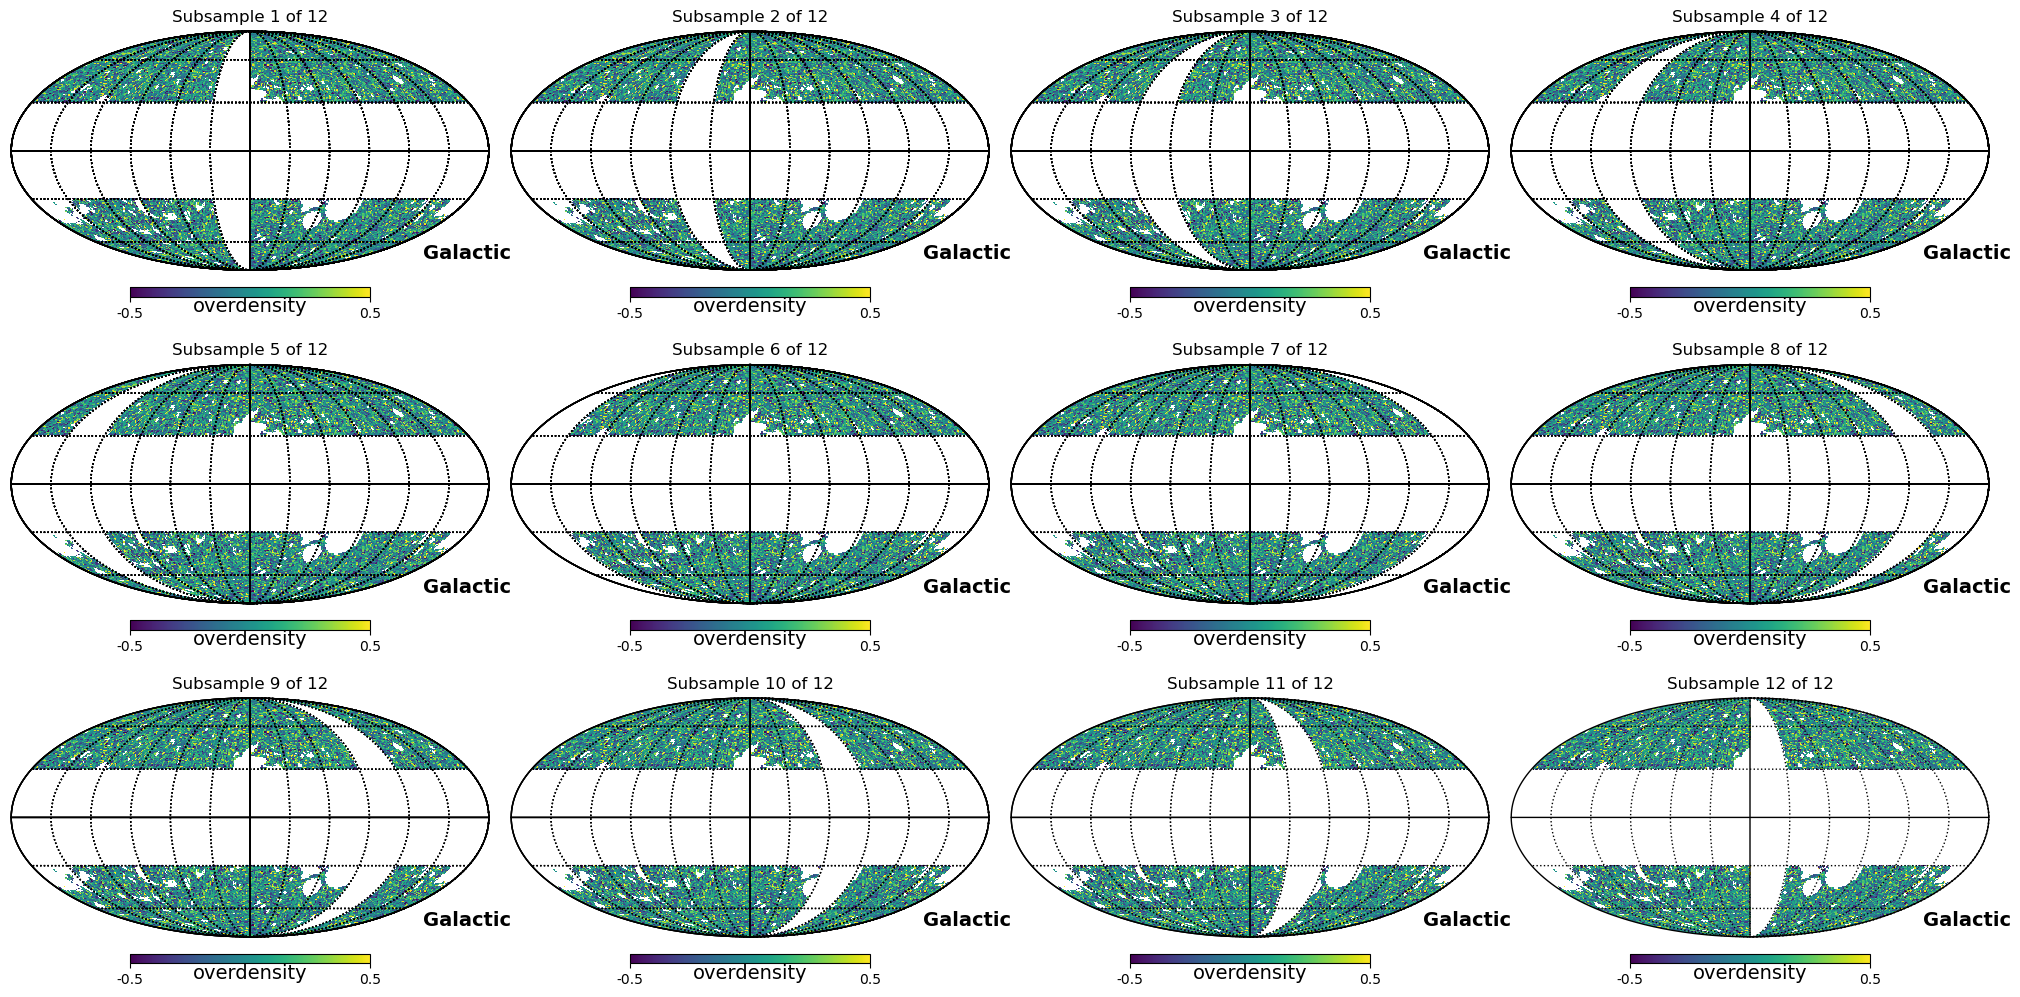

In [23]:
# plot the subsamples to check
fig = plt.figure(figsize=(20,10))
for i, subsample in enumerate(subsamples):
    hp.mollview(subsample, sub=(nsamples//4, nsamples//3, i+1), fig=fig, title=f'Subsample {i+1} of {nsamples}', **map_kwargs)
    hp.graticule()

In [24]:
# compute jk uncertainty in the FULL SAMPLE
lonavg, subsamples = get_longitude_subsamples_from_hpmap(overdensity_map_full, nsamples, input_frame='icrs')
# return the dipole components from each subsample too, to get uncertainty in the direction
jk_uncertainty_full, dipole_comps = compute_jackknife_uncertainty(subsamples, measure_dipole_in_overdensity_map, return_outputs=True)
avg_comps = np.nanmean(dipole_comps, axis=0)
avg_comps_norm = avg_comps / np.sqrt(avg_comps @ avg_comps)
angular_dist = np.rad2deg(np.array([
    np.arccos((comps @ avg_comps_norm) / np.sqrt(comps @ comps)) for comps in dipole_comps
])) # in degrees
# uncertainties
std_amp_full = np.linalg.norm(jk_uncertainty_full)
std_dist_full = np.sqrt(np.diag(covar_jackknife(angular_dist)))

In [25]:
# and in EACH REDSHIFT BIN
std_amps_z = np.empty(nbins)
std_dists_z = np.empty(nbins)
for i, overdensity_map in enumerate(overdensity_maps):
    lonavg, subsamples = get_longitude_subsamples_from_hpmap(overdensity_map, nsamples, input_frame='icrs')
    jk_uncertainty, dipole_comps = compute_jackknife_uncertainty(subsamples, measure_dipole_in_overdensity_map, return_outputs=True)
    avg_comps = np.nanmean(dipole_comps, axis=0)
    avg_comps_norm = avg_comps / np.sqrt(avg_comps @ avg_comps)
    angular_dist = np.rad2deg(np.array([
        np.arccos((comps @ avg_comps_norm) / np.sqrt(comps @ comps)) for comps in dipole_comps
    ])) # in degrees
    # uncertainties
    std_amps_z[i] = np.linalg.norm(jk_uncertainty)
    std_dists_z[i] = np.sqrt(np.diag(covar_jackknife(angular_dist)))

In [26]:
# overplot redshift distributions
bins = np.linspace(np.nanmin(redshifts_full), np.nanmax(redshifts_full), 101)
freq_full, bin_edges = np.histogram(redshifts_full, bins=bins)
freqs_z = [
    np.histogram(t_['redshift_quaia'], bins=bins)[0] for t_ in t_z_sorted
]
bin_avg = 0.5 * (bin_edges[1:] + bin_edges[:-1])

Text(0.5, 1.0, 'Measured dipole amplitudes in Quaia G<20.0, 2 redshift bins')

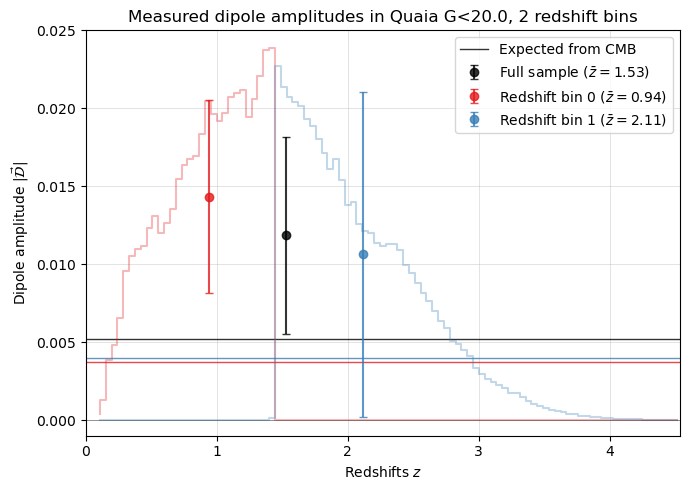

In [27]:
# plot the measured dipoles with the jackknife errors
#  and overplot redshift distributions
fig, ax = plt.subplots(figsize=(7,5), tight_layout=True)
kwargs = dict(marker='o', ls='None', alpha=0.8, capsize=3)
# for histogram of redshift distributions
hist_kwargs = dict(alpha=0.3)
norm = 0.024 # normalization to ~ match dipole amplitudes
# for expected dipole amplitude
expected_kwargs = dict(alpha=0.8, lw=1)

# full sample
ax.errorbar(np.mean(redshifts_full), np.linalg.norm(dipole_full), yerr=std_amp_full, c='k',
            label=r'Full sample ($\bar z=$'f'{np.mean(redshifts_full):.2f})', **kwargs)
ax.axhline(expected_dipamp_full, c='k', label='Expected from CMB', **expected_kwargs)

# redshift bins
for i, dipole_ in enumerate(dipoles_z):
    ax.errorbar(np.mean(redshifts_z[i]), np.linalg.norm(dipole_), yerr=std_amps_z[i], c=colors[i],
            label=f'Redshift bin {i}'r' ($\bar z=$'f'{np.mean(redshifts_z[i]):.2f})', **kwargs)
    ax.axhline(expected_dipamps_z[i], c=colors[i], **expected_kwargs)
    # source distribution
    ax.step(bin_avg, freqs_z[i] / np.max(freq_full) * norm, color=colors[i], **hist_kwargs)
ax.grid(alpha=0.5, lw=0.5)
ax.set_xlim(0., max(redshifts_full))
ax.set_ylim(-.001,.025)
ax.axhline(0., c='k', alpha=0.5, lw=0.5)
ax.set_xlabel(r'Redshifts $z$')
ax.set_ylabel(r'Dipole amplitude $|\vec\mathcal{D}|$')
ax.legend()
ax.set_title(f'Measured dipole amplitudes in Quaia G<{d.maglim}, {nbins} redshift bins')

#### dipole directions

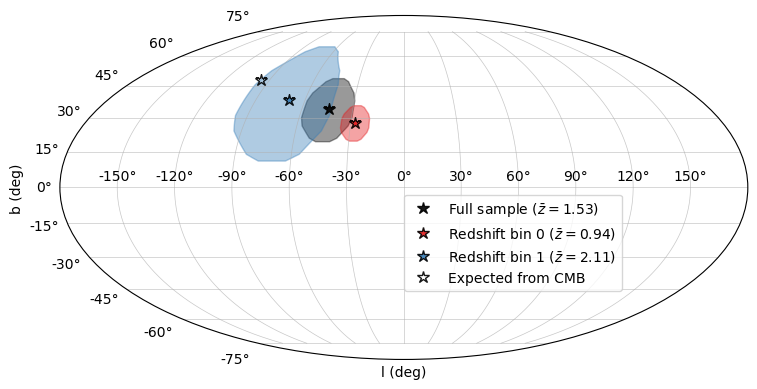

In [28]:
# sky plot
fig = plt.figure(figsize=(8,4))
ax = plt.subplot(111, projection='mollweide')

kwargs = dict(marker='*', ms=9, mec='k', ls='None', alpha=0.9)

# full sample:
# circles of uncertainty
circ = mpl.patches.Circle((Angle(dipole_full_dir.galactic.l).to(u.rad).wrap_at(np.pi*u.rad).value,
                            Angle(dipole_full_dir.galactic.b).to(u.rad).wrap_at(np.pi*u.rad).value),
                              radius=(std_dist_full*u.deg).to(u.rad).value, color='k', alpha=0.4)
ax.add_artist(circ)
ax.plot(Angle(dipole_full_dir.galactic.l).to(u.rad).wrap_at(np.pi*u.rad),
        Angle(dipole_full_dir.galactic.b).to(u.rad).wrap_at(np.pi*u.rad),
        c='k', label=r'Full sample ($\bar z=$'f'{np.mean(redshifts_full):.2f})', **kwargs)

# redshift bins:
for i, dipole_ in enumerate(dipoles_z):
    dipole_dir = dipole.get_dipole(dipole_)[1].galactic
    circ = mpl.patches.Circle((Angle(dipole_dir.l).to(u.rad).wrap_at(np.pi*u.rad).value,
                            Angle(dipole_dir.b).to(u.rad).wrap_at(np.pi*u.rad).value),
                              radius=(std_dists_z[i]*u.deg).to(u.rad).value, color=colors[i], alpha=0.4)
    ax.add_artist(circ)
    ax.plot(Angle(dipole_dir.l).to(u.rad).wrap_at(np.pi*u.rad),
        Angle(dipole_dir.b).to(u.rad).wrap_at(np.pi*u.rad),
        c=colors[i], label=f'Redshift bin {i}'r' ($\bar z=$'f'{np.mean(redshifts_z[i]):.2f})', **kwargs)
# CMB
cmb_dir = dipole.cmb_dipole()[1].galactic
ax.plot(Angle(cmb_dir.l, unit=u.rad).wrap_at(np.pi*u.rad),
        Angle(cmb_dir.b, unit=u.rad).wrap_at(np.pi*u.rad),
        c='None', label='Expected from CMB', **kwargs)

ax.set_xlabel('l (deg)')
ax.set_ylabel('b (deg)')
ax.legend(loc=(0.5,0.2))
ax.grid(True, lw=0.5, alpha=0.7)
fig.tight_layout()

### more binsssss

In [48]:
nbins = 6
t_z_sorted = sort_table_in_bins(d.table, nbins)

# redshift distribution in each bin
redshifts_z = [
    t_['redshift_quaia'] for t_ in t_z_sorted
]

# assign colors to each redshift bin to be consistent in plotting
colors = list(map(mpl.cm.Set1, range(nbins)))

Text(0.5, 1.0, 'Quaia G<20.5 redshift distributions, 6 bins')

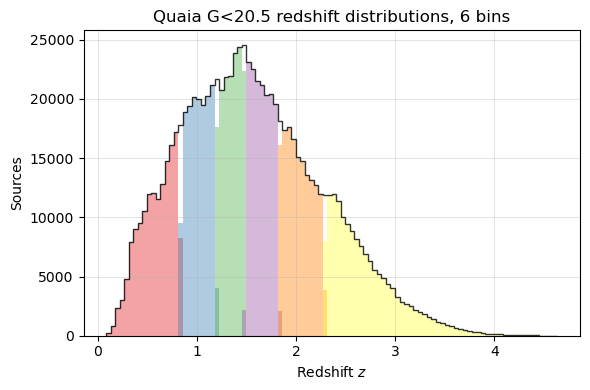

In [49]:
# plot dN/dz s
fig, ax = plt.subplots(figsize=(6,4), tight_layout=True)
bins = np.linspace(np.nanmin(redshifts_full), np.nanmax(redshifts_full), 101)
kwargs = dict(bins=bins, histtype='stepfilled', alpha=0.4)
_, _, _ = ax.hist(redshifts_full, color='k', histtype='step', alpha=0.8, bins=bins)
for i, zs in enumerate(redshifts_z):
    _, _, _ = ax.hist(zs, color=colors[i], **kwargs)
ax.grid(alpha=0.5, lw=0.5)
ax.set_xlabel(r'Redshift $z$')
ax.set_ylabel('Sources')
ax.set_title(f'Quaia G<{d.maglim} redshift distributions, {nbins} bins')

In [50]:
# EXPECTED DIPOLE AMPLITUDES
#  save full results dictionary to check parameters
expected_dipole_z_res = [
    compute_expected_dipole_gaia(t_, maglimit=maglim, min_g=19.5, max_g=20.5,
                                                   verbose=True, return_full_results=True) for t_ in t_z_sorted
]
# expected dipole amplitude for each bin
expected_dipamps_z = [
    res['expected_dipamp'] for res in expected_dipole_z_res
]

computing expected dipole from Ellis-Baldwin:
	effective alpha = 0.920
	number-count slope x = 0.897
	expected dipole amplitude = 0.0046
computing expected dipole from Ellis-Baldwin:
	effective alpha = 0.539
	number-count slope x = 1.151
	expected dipole amplitude = 0.0047
computing expected dipole from Ellis-Baldwin:
	effective alpha = 0.688
	number-count slope x = 1.170
	expected dipole amplitude = 0.0049
computing expected dipole from Ellis-Baldwin:
	effective alpha = 0.799
	number-count slope x = 1.223
	expected dipole amplitude = 0.0052
computing expected dipole from Ellis-Baldwin:
	effective alpha = 0.707
	number-count slope x = 1.215
	expected dipole amplitude = 0.0050
computing expected dipole from Ellis-Baldwin:
	effective alpha = 0.769
	number-count slope x = 1.071
	expected dipole amplitude = 0.0048


Text(0.5, 0.98, 'Quaia G<20.5 Ellis-Baldwin parameters')

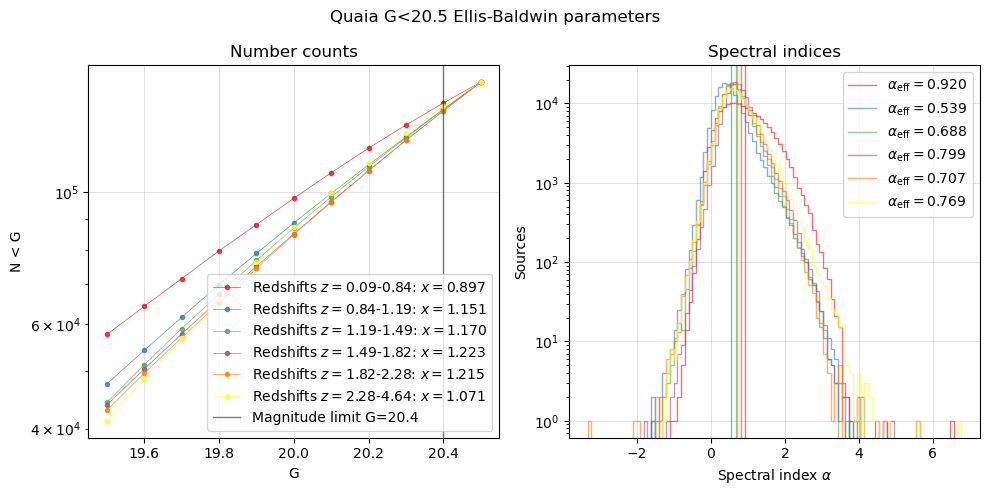

In [51]:
# make some plots
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(10,5), tight_layout=True)

# histogram bins
bins = np.linspace(min(np.concatenate([res['alphas'] for res in expected_dipole_z_res])),
                   max(np.concatenate([res['alphas'] for res in expected_dipole_z_res])), 101)
for i, res in enumerate(expected_dipole_z_res):
    mags, counts, x = res['mag_grid'], res['counts'], res['x']
    ax0.plot(mags, counts, marker='.', ls='-', lw=0.5, color=colors[i], alpha=0.8,
            label=f'Redshifts 'r'$z=$'f'{min(redshifts_z[i]):.2f}-{max(redshifts_z[i]):.2f}: 'r'$x=$'f'{x:.3f}')
    alpha, alphas = res['alpha'], res['alphas']
    _, _, _ = ax1.hist(alphas, bins=bins, alpha=0.6, color=colors[i], histtype='step')
    ax1.axvline(alpha, color=colors[i], alpha=0.6, lw=1, label=r'$\alpha_\mathrm{eff}=$'f'{alpha:.3f}')
    
ax0.axvline(maglim, color='k', alpha=0.5, lw=1, label=f'Magnitude limit G={maglim}')
ax0.set_xlabel('G')
ax0.set_ylabel('N < G')
ax0.set_title('Number counts')

ax1.set_xlabel(r'Spectral index $\alpha$')
ax1.set_ylabel(r'Sources')
ax1.set_title('Spectral indices')

for ax in (ax0, ax1):
    ax.grid(lw=0.5, alpha=0.5)
    ax.semilogy()
    ax.legend()
fig.suptitle(f'Quaia G<{d.maglim} Ellis-Baldwin parameters')

In [52]:
# selection functions for each redshift bin
selfuncs_z = [
    tools.flatten_map(fitsio.read(os.path.join(d.catdir, 'selfuncs',
                             f'selection_function_NSIDE{d.NSIDE}_G{d.maglim}_zsplit{nbins}bin{i}CIB.fits'))) for i in range(nbins)
]

In [53]:
# OVERDENSITY MAP from each source density table / each redshift slice and fit dipole
overdensity_maps = np.empty((nbins, hp.nside2npix(d.NSIDE)))
for i, t_ in enumerate(t_z_sorted):
    # turn astropy table into healpix map
    datamap = tools.load_catalog_as_map(t_, NSIDE=d.NSIDE)

    # selection function: from the full sample
    selfunc_ = selfuncs_z[i]

    # total mask: galactic plane, smaller masks, and where completeness < 0.5
    mask_ = gal_plane_mask.astype(bool) & small_masks.astype(bool) & (selfunc_ > 0.5)
    
    # mask the data: populate a nan map with the data values in unmasked pixels
    masked_datamap = np.multiply(datamap, mask_, where=mask_, out=np.full_like(datamap, np.nan))
    
    # mean density of the map: mean of the _expected_ counts
    mean_density = np.nanmean(masked_datamap / selfunc_)
    
    # then the overdensity map is
    overdensity_maps[i] = np.divide(masked_datamap, selfunc_, where=mask_,
                                out=np.full_like(masked_datamap, np.nan)) / mean_density - 1
                        # (fancy divide to avoid RuntimeWarnings where completeness goes to zero)

# FIT DIPOLE to each map
dipoles_z = np.empty((nbins,3))
for i, overdensity_map in enumerate(overdensity_maps):
    print(f"dipole measured in Quaia G<{d.maglim}, redshift bin {i}:")
    dipole_ = measure_dipole_in_overdensity_map(overdensity_map, selfunc=selfuncs_z[i])
    print(f"\tbest-fit dipole amp. =\t{np.linalg.norm(dipole_):.5f}")
    print(f"\texpected dipole amp. =\t{expected_dipamps_z[i]:.5f}\n\tratio =\t\t\t{np.linalg.norm(dipole_) / expected_dipamps_z[i]:.4f}")
    dipoles_z[i] = dipole_

dipole measured in Quaia G<20.5, redshift bin 0:
	best-fit dipole amp. =	0.01201
	expected dipole amp. =	0.00459
	ratio =			2.6147
dipole measured in Quaia G<20.5, redshift bin 1:
	best-fit dipole amp. =	0.02627
	expected dipole amp. =	0.00465
	ratio =			5.6471
dipole measured in Quaia G<20.5, redshift bin 2:
	best-fit dipole amp. =	0.00783
	expected dipole amp. =	0.00490
	ratio =			1.5974
dipole measured in Quaia G<20.5, redshift bin 3:
	best-fit dipole amp. =	0.01612
	expected dipole amp. =	0.00518
	ratio =			3.1108
dipole measured in Quaia G<20.5, redshift bin 4:
	best-fit dipole amp. =	0.01119
	expected dipole amp. =	0.00503
	ratio =			2.2268
dipole measured in Quaia G<20.5, redshift bin 5:
	best-fit dipole amp. =	0.00954
	expected dipole amp. =	0.00480
	ratio =			1.9848


In [54]:
# JACKKNIFE in each redshift bin
std_amps_z = np.empty(nbins)
std_dists_z = np.empty(nbins)
for i, overdensity_map in enumerate(overdensity_maps):
    lonavg, subsamples = get_longitude_subsamples_from_hpmap(overdensity_map, nsamples, input_frame='icrs')
    jk_uncertainty, dipole_comps = compute_jackknife_uncertainty(subsamples, measure_dipole_in_overdensity_map, return_outputs=True)
    avg_comps = np.nanmean(dipole_comps, axis=0)
    avg_comps_norm = avg_comps / np.sqrt(avg_comps @ avg_comps)
    angular_dist = np.rad2deg(np.array([
        np.arccos((comps @ avg_comps_norm) / np.sqrt(comps @ comps)) for comps in dipole_comps
    ])) # in degrees
    # uncertainties
    std_amps_z[i] = np.linalg.norm(jk_uncertainty)
    std_dists_z[i] = np.sqrt(np.diag(covar_jackknife(angular_dist)))

In [55]:
# overplot redshift distributions
bins = np.linspace(np.nanmin(redshifts_full), np.nanmax(redshifts_full), 101)
freq_full, bin_edges = np.histogram(redshifts_full, bins=bins)
freqs_z = [
    np.histogram(t_['redshift_quaia'], bins=bins)[0] for t_ in t_z_sorted
]
bin_avg = 0.5 * (bin_edges[1:] + bin_edges[:-1])

Text(0.5, 1.0, 'Measured dipole amplitudes in Quaia G<20.5, 6 redshift bins')

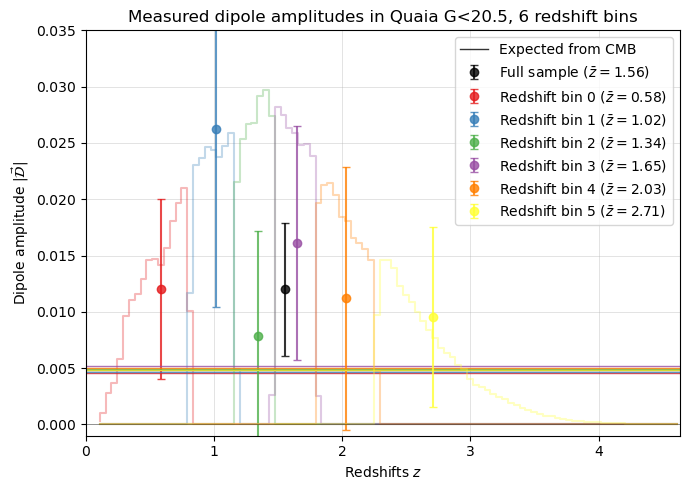

In [56]:
# plot the measured dipoles with the jackknife errors
#  and overplot redshift distributions
fig, ax = plt.subplots(figsize=(7,5), tight_layout=True)
kwargs = dict(marker='o', ls='None', alpha=0.8, capsize=3)
# for histogram of redshift distributions
hist_kwargs = dict(alpha=0.3)
norm = 0.03 # normalization to ~ match dipole amplitudes
# for expected dipole amplitude
expected_kwargs = dict(alpha=0.8, lw=1)

# full sample
ax.errorbar(np.mean(redshifts_full), np.linalg.norm(dipole_full), yerr=std_amp_full, c='k',
            label=r'Full sample ($\bar z=$'f'{np.mean(redshifts_full):.2f})', **kwargs)
ax.axhline(expected_dipamp_full, c='k', label='Expected from CMB', **expected_kwargs)

# redshift bins
for i, dipole_ in enumerate(dipoles_z):
    ax.errorbar(np.mean(redshifts_z[i]), np.linalg.norm(dipole_), yerr=std_amps_z[i], c=colors[i],
            label=f'Redshift bin {i}'r' ($\bar z=$'f'{np.mean(redshifts_z[i]):.2f})', **kwargs)
    ax.axhline(expected_dipamps_z[i], c=colors[i], **expected_kwargs)
    # source distribution
    ax.step(bin_avg, freqs_z[i] / np.max(freq_full) * norm, color=colors[i], **hist_kwargs)
ax.grid(alpha=0.5, lw=0.5)
ax.set_xlim(0., max(redshifts_full))
ax.set_ylim(-.001,.035)
ax.axhline(0., c='k', alpha=0.5, lw=0.5)
ax.set_xlabel(r'Redshifts $z$')
ax.set_ylabel(r'Dipole amplitude $|\vec\mathcal{D}|$')
ax.legend()
ax.set_title(f'Measured dipole amplitudes in Quaia G<{d.maglim}, {nbins} redshift bins')

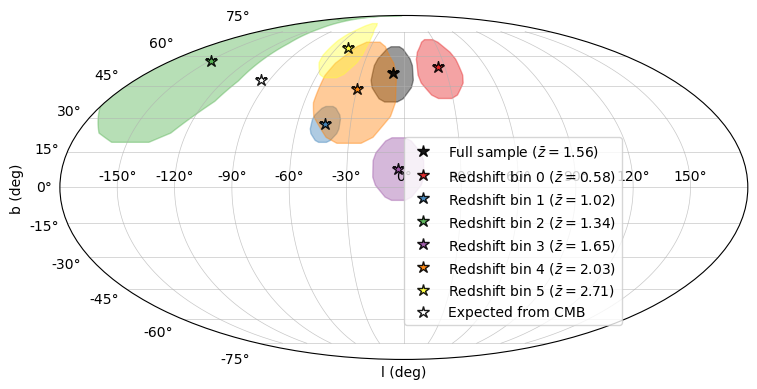

In [57]:
# sky plot
fig = plt.figure(figsize=(8,4))
ax = plt.subplot(111, projection='mollweide')

kwargs = dict(marker='*', ms=9, mec='k', ls='None', alpha=0.9)

# full sample:
# circles of uncertainty
circ = mpl.patches.Circle((Angle(dipole_full_dir.galactic.l).to(u.rad).wrap_at(np.pi*u.rad).value,
                            Angle(dipole_full_dir.galactic.b).to(u.rad).wrap_at(np.pi*u.rad).value),
                              radius=(std_dist_full*u.deg).to(u.rad).value, color='k', alpha=0.4)
ax.add_artist(circ)
ax.plot(Angle(dipole_full_dir.galactic.l).to(u.rad).wrap_at(np.pi*u.rad),
        Angle(dipole_full_dir.galactic.b).to(u.rad).wrap_at(np.pi*u.rad),
        c='k', label=r'Full sample ($\bar z=$'f'{np.mean(redshifts_full):.2f})', **kwargs)

# redshift bins:
for i, dipole_ in enumerate(dipoles_z):
    dipole_dir = dipole.get_dipole(dipole_)[1].galactic
    circ = mpl.patches.Circle((Angle(dipole_dir.l).to(u.rad).wrap_at(np.pi*u.rad).value,
                            Angle(dipole_dir.b).to(u.rad).wrap_at(np.pi*u.rad).value),
                              radius=(std_dists_z[i]*u.deg).to(u.rad).value, color=colors[i], alpha=0.4)
    ax.add_artist(circ)
    ax.plot(Angle(dipole_dir.l).to(u.rad).wrap_at(np.pi*u.rad),
        Angle(dipole_dir.b).to(u.rad).wrap_at(np.pi*u.rad),
        c=colors[i], label=f'Redshift bin {i}'r' ($\bar z=$'f'{np.mean(redshifts_z[i]):.2f})', **kwargs)
# CMB
cmb_dir = dipole.cmb_dipole()[1].galactic
ax.plot(Angle(cmb_dir.l, unit=u.rad).wrap_at(np.pi*u.rad),
        Angle(cmb_dir.b, unit=u.rad).wrap_at(np.pi*u.rad),
        c='None', label='Expected from CMB', **kwargs)

ax.set_xlabel('l (deg)')
ax.set_ylabel('b (deg)')
ax.legend(loc=(0.5,0.1))
ax.grid(True, lw=0.5, alpha=0.7)
fig.tight_layout()